In [ ]:
####
# exercise 1: coupled time series data in parallel
#             (nb_iters = 150, batch_size = 10, hidden_dim = 12)
# exercise 2: 1 series which superposition of 2 different sine waves 
#             (nb_iters = 2500, batch_size = 50, hidden_dim = 35)
# exercise 3: exercise 2 + noisy data
# exercise 4: introducing feedback into the decoder
# exercise 5: predicting future value of Bitcoin

In [37]:
exercise = 4  # Possible values: 1, 2, 3, 4 or 5. 

from datasets import generate_x_y_data_v1, generate_x_y_data_v2, generate_x_y_data_v3, generate_x_y_data_v4 

# We choose which data function to use below, in function of the exericse. 
if exercise == 1:
    generate_x_y_data = generate_x_y_data_v1
if exercise == 2:
    generate_x_y_data = generate_x_y_data_v2
if exercise in [3, 4]:
    # Les exercices 3 et 4 utilisent les même données. 
    generate_x_y_data = generate_x_y_data_v3
if exercise == 5:  
    generate_x_y_data = generate_x_y_data_v4

In [38]:
import tensorflow as tf  # Version 1.0 or 0.12
import numpy as np
import matplotlib.pyplot as plt

# This is for the notebook to generate inline matplotlib 
# charts rather than to open a new window every time: 
%matplotlib inline

In [39]:
sample_x, sample_y = generate_x_y_data(isTrain=True, batch_size=3)
print ("Dimensions of the dataset for 3 X and 3 Y training examples : ")
print (sample_x.shape)
print (sample_y.shape)
print ("seq_length, batch_size, output_dim")

# Internal neural network parameters
seq_length = sample_x.shape[0]  # Time series will have the same past and future (to be predicted) lenght. 
batch_size = 50  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

output_dim = input_dim = sample_x.shape[-1]  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 35  # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 2  # Number of stacked recurrent cells, on the neural depth axis. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
nb_iters = 2500  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

Dimensions of the dataset for 3 X and 3 Y training examples : 
(30, 3, 1)
(30, 3, 1)
seq_length, batch_size, output_dim


In [40]:
# Backward compatibility for TensorFlow's version 0.12: 
try:
    tf.nn.seq2seq = tf.contrib.legacy_seq2seq
    tf.nn.rnn_cell = tf.contrib.rnn
    tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
    print ("TensorFlow's version : 1.0 (or more)")
except: 
    print ("TensorFlow's version : 0.12")

TensorFlow's version : 1.0 (or more)


In [41]:
tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):

    # Encoder: inputs
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(seq_length)
    ]

    # Decoder: expected outputs
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
          for t in range(seq_length)
    ]
    
    # Give a "GO" token to the decoder. 
    # You might want to revise what is the appended value "+ enc_inp[:-1]". 
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + enc_inp[:-1]

    # Create a `layers_stacked_count` of stacked RNNs (GRU cells here). 
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    # For reshaping the input and output dimensions of the seq2seq RNN: 
    w_in = tf.Variable(tf.random_normal([input_dim, hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim], mean=1.0))
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    reshaped_inputs = [tf.nn.relu(tf.matmul(i, w_in) + b_in) for i in enc_inp]
    
    # Here, the encoder and the decoder uses the same cell, HOWEVER,
    # the weights aren't shared among the encoder and decoder, we have two
    # sets of weights created under the hood according to that function's def. 
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp, 
        dec_inp, 
        cell
    )
    
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    # Final outputs: with linear rescaling similar to batch norm, 
    # but without the "norm" part of batch normalization hehe. 
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]

In [42]:
# Training loss and optimizer

with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        
    # L2 regularization (to avoid overfitting and to have a  better generalization capacity)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
            
    loss = output_loss + lambda_l2_reg * reg_loss

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)

In [43]:
def train_batch(batch_size):
    """
    Training step that optimizes the weights 
    provided some batch_size X and Y examples from the dataset. 
    """
    X, Y = generate_x_y_data(isTrain=True, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

def test_batch(batch_size):
    """
    Test step, does NOT optimizes. Weights are frozen by not <
    doing sess.run on the train_op. 
    """
    X, Y = generate_x_y_data(isTrain=False, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]


# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    
    if t % 10 == 0: 
        # Tester
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print ("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters, train_loss, test_loss))

print ("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))

Step 0/2500, train loss: 166.85191345214844, 	TEST loss: 736.260498046875
Step 10/2500, train loss: 126.00711822509766, 	TEST loss: 112.56956481933594
Step 20/2500, train loss: 109.52734375, 	TEST loss: 118.80953216552734
Step 30/2500, train loss: 122.7364730834961, 	TEST loss: 117.99602508544922
Step 40/2500, train loss: 115.30231475830078, 	TEST loss: 115.0010757446289
Step 50/2500, train loss: 126.76790618896484, 	TEST loss: 105.14373016357422
Step 60/2500, train loss: 113.12134552001953, 	TEST loss: 106.45488739013672
Step 70/2500, train loss: 126.99107360839844, 	TEST loss: 119.2642822265625
Step 80/2500, train loss: 117.36306762695312, 	TEST loss: 114.73193359375
Step 90/2500, train loss: 114.21678161621094, 	TEST loss: 115.22965240478516
Step 100/2500, train loss: 118.56849670410156, 	TEST loss: 121.6512451171875
Step 110/2500, train loss: 109.17112731933594, 	TEST loss: 120.247314453125
Step 120/2500, train loss: 116.32878875732422, 	TEST loss: 103.51883697509766
Step 130/2500,

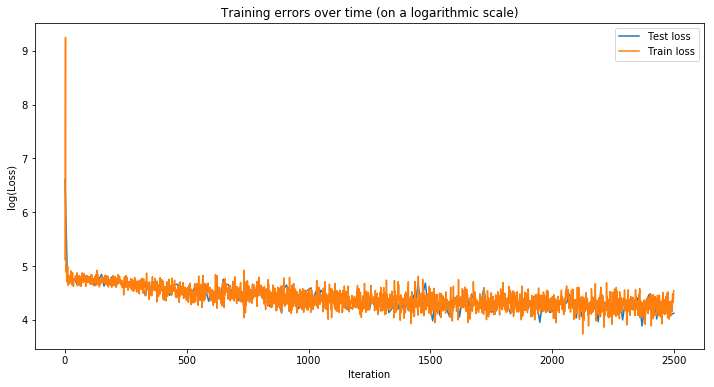

In [44]:
# Graphique des erreurs au fil du temps :
plt.figure(figsize=(12, 6))
plt.plot(
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss"
)
plt.plot(
    np.log(train_losses), 
    label="Train loss"
)
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()

Let's visualize 5 predictions with our signals:


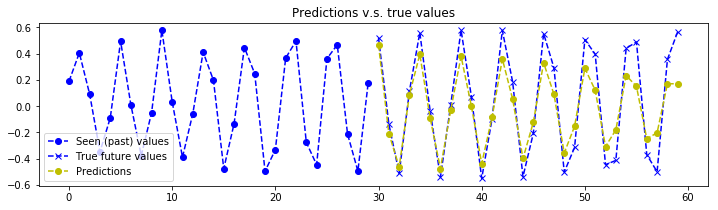

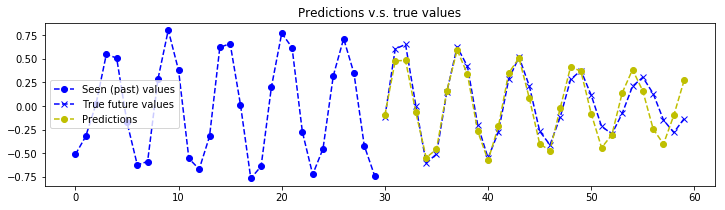

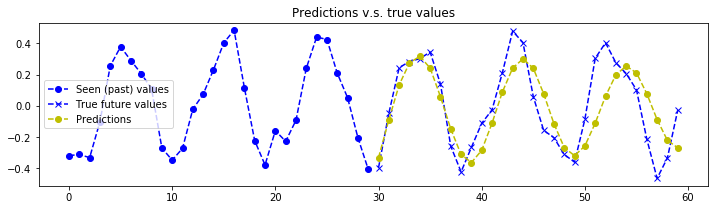

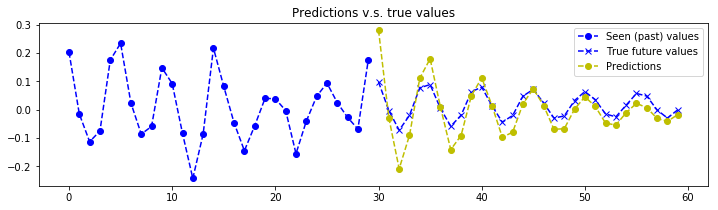

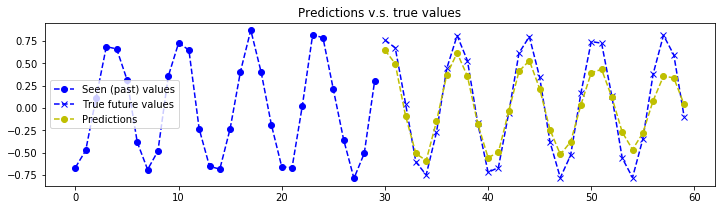

Reminder: the signal can contain many dimensions at once.
In that case, signals have the same color.
In reality, we could imagine multiple stock market symbols evolving,
tied in time together and seen at once by the neural network.


In [45]:
# Tester
nb_predictions = 5
print ("Let's visualize {} predictions with our signals:".format(nb_predictions))

X, Y = generate_x_y_data(isTrain=False, batch_size=nb_predictions)
feed_dict = {enc_inp[t]: X[t] for t in range(seq_length)}
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])

for j in range(nb_predictions): 
    plt.figure(figsize=(12, 3))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs[:,j,k]
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

print ("Reminder: the signal can contain many dimensions at once.")
print ("In that case, signals have the same color.")
print ("In reality, we could imagine multiple stock market symbols evolving,")
print ("tied in time together and seen at once by the neural network.")